# Dairy Trading Strategies: Cross-Commodity Spread Trades

In [29]:
# Dairy Trading Strategies: Cross-Commodity Spread Trades

## Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
## Fetch market data
# Define the tickers
tickers = ['DC=F', 'CB=F', 'CSC=F', 'NZDUSD=X', 'FCG.NZ', 'ZS=F', 'ZC=F', 'ZW=F']

# Fetch the data
data = yf.download(tickers, start="2020-01-01", end="2024-05-01")

## Data preprocessing
# Drop NaN values and calculate daily returns
data = data['Adj Close'].dropna()
returns = data.pct_change().dropna()

[*********************100%%**********************]  8 of 8 completed


In [31]:
## Calculate rolling correlations for 30, 60, and 90 days
rolling_corr_30d = returns.rolling(window=30).corr()
rolling_corr_60d = returns.rolling(window=60).corr()
rolling_corr_90d = returns.rolling(window=90).corr()

## Initialize dictionary to store weighted rolling correlations for each pair
rolling_corr_dict = {}

# Calculate weighted rolling correlations for each pair
for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        pair = (tickers[i], tickers[j])
        rolling_corr_30d_series = rolling_corr_30d.loc[(slice(None), tickers[i]), tickers[j]].unstack(level=-1)
        rolling_corr_60d_series = rolling_corr_60d.loc[(slice(None), tickers[i]), tickers[j]].unstack(level=-1)
        rolling_corr_90d_series = rolling_corr_90d.loc[(slice(None), tickers[i]), tickers[j]].unstack(level=-1)
        
        # Calculate the weighted average
        rolling_corr_dict[pair] = (1.5 * rolling_corr_30d_series + 1 * rolling_corr_60d_series + 0.5 * rolling_corr_90d_series) / 3

## Identify high correlation pairs
threshold = 0.7
high_corr_pairs = []

for pair, corr_series in rolling_corr_dict.items():
    last_valid_corr = corr_series.dropna().iloc[-1]  # Get the last valid value of the rolling correlation
    last_valid_corr_value = last_valid_corr.item()  # Extract the float value from the Series
    if last_valid_corr_value > threshold:
        high_corr_pairs.append(pair)

print("\nHigh Correlation Pairs:")
print(high_corr_pairs)


High Correlation Pairs:
[('DC=F', 'CSC=F')]


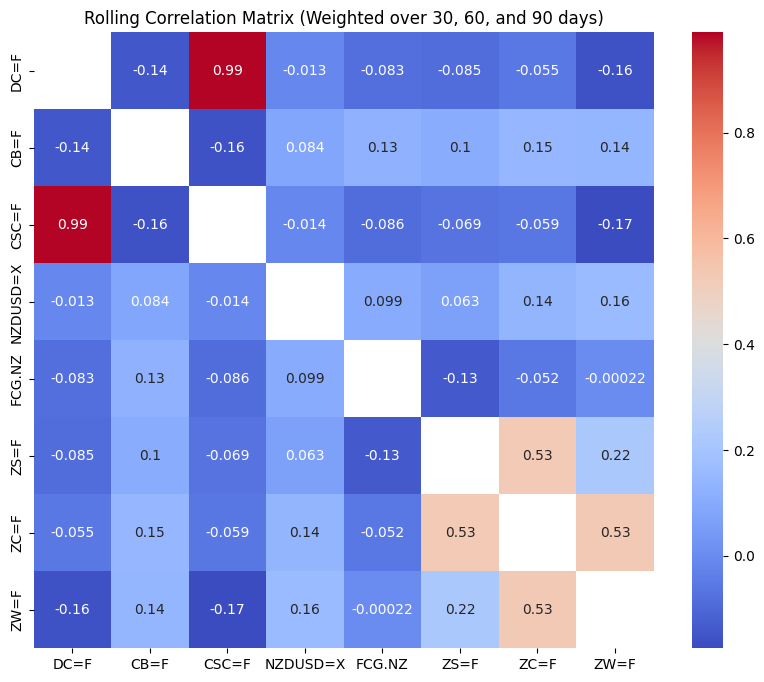

In [32]:
## Calculate and plot the rolling correlation matrix using the weighted rolling correlations
rolling_corr_matrix = pd.DataFrame(index=tickers, columns=tickers)

for pair, corr_series in rolling_corr_dict.items():
    last_valid_corr = corr_series.dropna().iloc[-1]
    last_valid_corr_value = last_valid_corr.item()
    rolling_corr_matrix.loc[pair[0], pair[1]] = last_valid_corr_value
    rolling_corr_matrix.loc[pair[1], pair[0]] = last_valid_corr_value

rolling_corr_matrix = rolling_corr_matrix.astype(float)

## Plot the rolling correlation matrix
plt.figure(figsize=(10, 8))
plt.title('Rolling Correlation Matrix (Weighted over 30, 60, and 90 days)')
sns.heatmap(rolling_corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Pair: ('DC=F', 'CSC=F')
Total P&L: 468.36909425258636



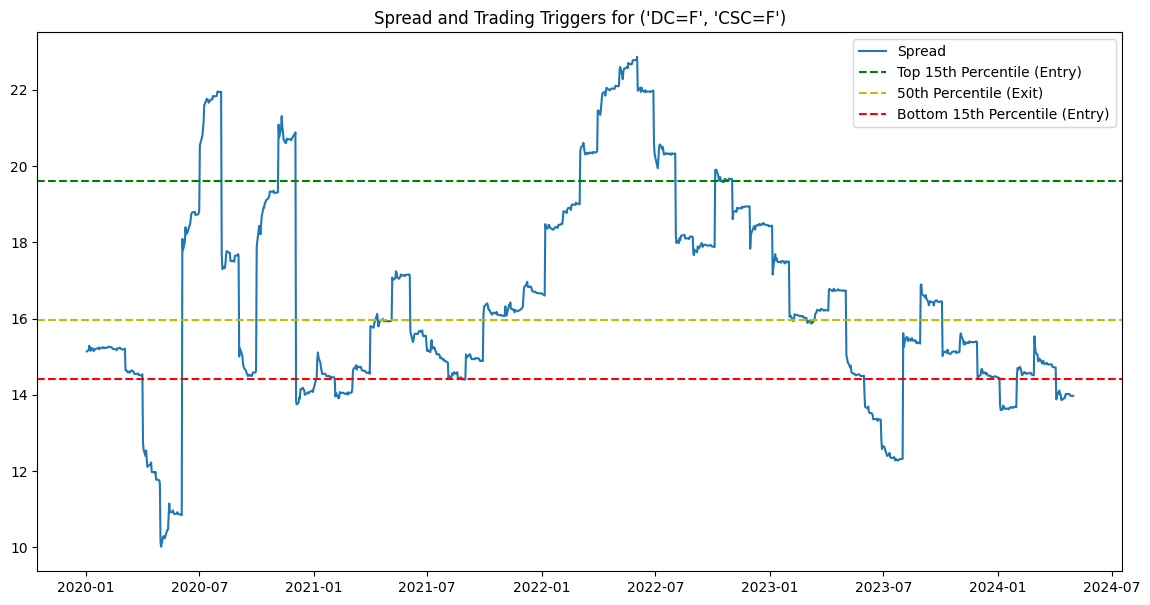

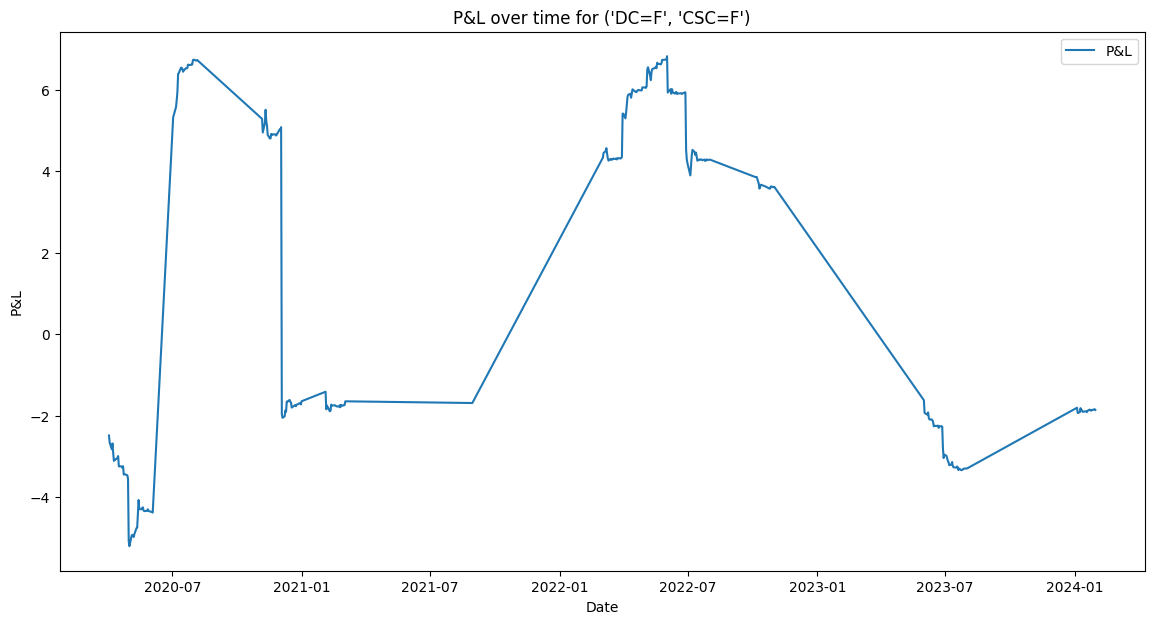

In [33]:
## Analyze and trade the spread for each high correlation pair
results = []

for pair in high_corr_pairs:
    asset1, asset2 = pair
    spread = data[asset1] - data[asset2]
    
    # Calculate percentiles
    top_percentile = spread.quantile(0.85)
    bottom_percentile = spread.quantile(0.15)
    exit_percentile = spread.quantile(0.50)
    
    # Entry points: spread is in the top or bottom 15th percentile
    entry_points = spread[(spread > top_percentile) | (spread < bottom_percentile)].index
    
    # Exit points: spread returns to the 50th percentile
    exit_points = spread[(spread > exit_percentile - 0.01 * spread_std) & (spread < exit_percentile + 0.01 * spread_std)].index
    
    # Match entry and exit points: ensure each entry has a corresponding exit after it
    matched_entry_points = []
    matched_exit_points = []
    stop_loss_points = []
    
    for entry in entry_points:
        possible_exits = exit_points[exit_points > entry]
        if not possible_exits.empty:
            exit_point = possible_exits[0]
            matched_entry_points.append(entry)
            matched_exit_points.append(exit_point)
            
            # Determine stop loss level
            entry_value = spread.loc[entry]
            stop_loss_value = entry_value + 1.5 * spread_std if entry_value > spread_mean else entry_value - 1.5 * spread_std
            stop_loss_points.append(stop_loss_value)
    
    # Calculate P&L based on trading the spread
    pnl = []
    for i in range(len(matched_entry_points)):
        entry = matched_entry_points[i]
        exit = matched_exit_points[i]
        stop_loss_value = stop_loss_points[i]
        
        entry_value = spread.loc[entry]
        exit_value = spread.loc[exit]
        
        if entry_value > spread_mean:
            # Short position: Buy back at exit or stop-loss
            if exit_value < stop_loss_value:
                pnl.append(entry_value - exit_value)  # Take profit at exit
            else:
                stop_loss_exit = spread[spread.index > entry][spread < stop_loss_value].index[0]
                pnl.append(entry_value - spread.loc[stop_loss_exit])  # Stop loss
        else:
            # Long position: Sell at exit or stop-loss
            if exit_value > stop_loss_value:
                pnl.append(exit_value - entry_value)  # Take profit at exit
            else:
                stop_loss_exit = spread[spread.index > entry][spread > stop_loss_value].index[0]
                pnl.append(spread.loc[stop_loss_exit] - entry_value)  # Stop loss
    
    results.append({
        'pair': pair,
        'spread': spread,
        'entry_points': matched_entry_points,
        'exit_points': matched_exit_points,
        'pnl': pnl,
        'total_pnl': np.sum(pnl)
    })

## Display P&L results
for result in results:
    print(f"Pair: {result['pair']}")
    print(f"Total P&L: {result['total_pnl']}")
    print()

    # Plot the spread and triggers
    spread = result['spread']
    plt.figure(figsize=(14, 7))
    plt.plot(spread, label='Spread')
    plt.axhline(result['spread'].quantile(0.85), color='g', linestyle='--', label='Top 15th Percentile (Entry)')
    plt.axhline(result['spread'].quantile(0.50), color='y', linestyle='--', label='50th Percentile (Exit)')
    plt.axhline(result['spread'].quantile(0.15), color='r', linestyle='--', label='Bottom 15th Percentile (Entry)')
    plt.legend()
    plt.title(f'Spread and Trading Triggers for {result["pair"]}')
    plt.show()

    # Plot the P&L over time
    plt.figure(figsize=(14, 7))
    plt.plot(result['entry_points'], result['pnl'], label='P&L')
    plt.legend()
    plt.title(f'P&L over time for {result["pair"]}')
    plt.xlabel('Date')
    plt.ylabel('P&L')
    plt.show()